This file contains the computing of the spatial autocorrelation with Moran's I

In [20]:
# Import all the needed libraries for calculating Moran's I 

import seaborn as sns
import pandas as pd
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
from esda import Moran
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
import sys
from scipy.spatial import distance_matrix


# Import the Queen function from the respective library
from libpysal.weights import Queen



In [9]:
# Loading and reading the datafile

file_path = 'C:\\Users\\rober\\OneDrive\\المستندات\\MADE Metropolitan Data 1 Assignments Robert\\brexit.gpkg'

brexit = gpd.read_file(file_path)

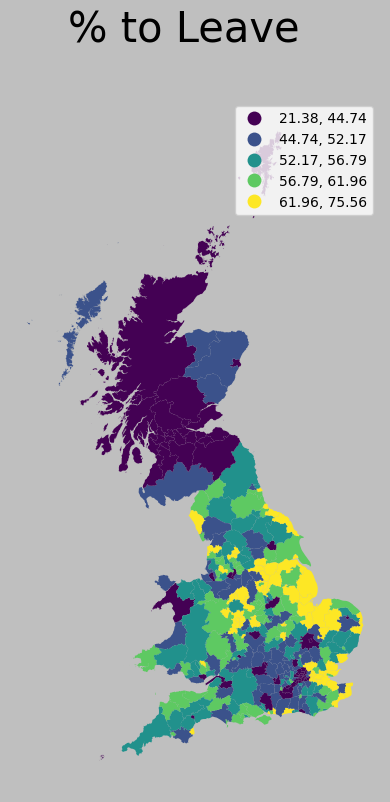

In [10]:
# Creating a basis choropleth map of the data

# Set up figure and axis. One figure and one axis is used in the plot with 9 inches for both the width and length creating a square.
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot of a specific column. Pct-Leave can be replaced here with the data we are working with.
# 'Quantiles' means the data will be divided into equal-sized groups based on quantiles (e.g., quartiles, quintiles, etc.). 
# This is useful for visualizing data distributions where each color represents a specific quantile range (e.g., 25% of the regions with the lowest values are in one color, the next 25% in another, etc.).
# A legend is included with legend=True
# ax=ax allows you to place the map plot on a specific figure and axes, as opposed to letting geopandas create its own figure.
brexit.plot(column='Pct_Leave', scheme='Quantiles', 
        legend=True, ax=ax)

# Remove axis frame
ax.set_axis_off()

# Change background color of the figure
f.set_facecolor('0.75')

# Title
f.suptitle('% to Leave', size=30)

# Draw
plt.show()

In [11]:
# Building a Continuity-Based Weight Matrix

# Define the function
def construct_queen_weight_matrix(brexit):
    """
    1. This line of code filters out the invalid rows of the geodataframe. Invalid values could include intersections between areas and themselves for example.
        The rectangular brackets function as a filter, where the 'is_valid' term could be seen as a 'True' statement creating Boolean values.
    2. The term 'Queen' creates a Queen continuity weight matrix. This matrix is based on whether two different areas either border and/or corner each other.
        The 'Queen' function is used on the selected geodataframe (gdf) and named queen_w. Ultimatly this value is returned.
    """

    brexit = brexit[brexit.is_valid]

    queen_w = Queen.from_dataframe(brexit)

    return queen_w

In [14]:
# Printing the given continuity-based weight matrix to show what the matrix looks like. It can be interesting to see what output is given.
# The .full()[0] provides the first row that is full of the weight matrix. Therein, it can provide a better output example than a row that is not.
# Other than this line of code calls to print the weight matrix function.

print(construct_queen_weight_matrix(brexit).full()[0])

C:\Users\rober\AppData\Local\Temp\ipykernel_19020\4279239000.py:17: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen_w = Queen.from_dataframe(brexit)


[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


c:\Users\rober\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: 45, 51, 331, 339, 342, 358.
  W.__init__(self, neighbors, ids=ids, **kw)


In [17]:
# Creating a function for Moran's I
"""
1. The capital W stands for the spatial weight matrix. We use it to express the relationship between two locations.
    The y stands for specific values of a certain location which are yet to be determined.
"""
def calculate_morans_i(W, y):
    
    # Calculate Moran's I
    """
    2. The Moran function from the esda module is used. The focus is on analyzing the specific values of each area relative to their spatial arrangement.
        That is why y is the first argument here and then W follows.
    """
    moran = esda.Moran(y, W)
    
    # Return Moran's I value, p-value
    """
    3. The Moran's I is returned together with the p-value. The p-value is included here to consider whether the Moran's I calculation is statistically significant.
    """
    return moran.I, moran.p_sim

# Create the spatial weights matrix (Queen contiguity)
W = weights.Queen.from_dataframe(brexit)

# Extract the attribute array for Valid Vote. This column can be replaced by any column that we are using.
y = brexit['Valid_Vote'].values  

# Call the function to calculate Moran's I 
morans_i_value, p_value = calculate_morans_i(W, y)

print(morans_i_value, p_value)


C:\Users\rober\AppData\Local\Temp\ipykernel_19020\3386469788.py:22: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  W = weights.Queen.from_dataframe(brexit)


('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 51, ' is an island (no neighbors)')
('WARNING: ', 331, ' is an island (no neighbors)')
('WARNING: ', 339, ' is an island (no neighbors)')
('WARNING: ', 342, ' is an island (no neighbors)')
('WARNING: ', 358, ' is an island (no neighbors)')
0.20107614963794007 0.001


c:\Users\rober\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: 45, 51, 331, 339, 342, 358.
  W.__init__(self, neighbors, ids=ids, **kw)


In [23]:
# Standardizing Spatial Weight Matrices

def Standardized_weights(W):
    """ 
    1. This function recieves spatial weight matrix W.
    2. Then it sums up each row's values and divide them by overall of the row accordingly, and
    3. Returns the standardized weight matrix.

    """
    # Creating a copy of weight matrix
    Standardized_Weights = W.copy()
    
    # Calculating sum of values in the same row
    for i in Standardized_Weights.neighbors:

        overall_weight = Standardized_Weights.sum(axis = i)
        
        # standardize each value, if the overall is not 0 (we have neighborhood there)
        if overall_weight > 0:

            for j in  Standardized_Weights.neighbors[i]:
                Standardized_Weights[i][j]= Standardized_Weights[i][j] / overall_weight
                return


    
    return Standardized_Weights

In [25]:
# Creating Distance-Based Weights

# Creates a distance-based spatial weight matrix. The coordinates give specific location in the space. 
# The threshold_distance determines what is considered to be a neighboring distance.

def create_distance_weights(coordinates, threshold_distance):
    
    # In this string an array is formed of the coordinates using the numpy library, which makes it easier to use the data in python functions.
    
    coords_array = np.array(coordinates)
    
    # I formed a distance matrix with the arrays of the coordinates that computes the distance between each point in the array.
    
    dist_matrix = distance_matrix(coords_array, coords_array)
    
    # A Boolean comparision is called using the '<=' to create the weight matrix with only 0's and 1's. 
    # This last piece of information is ensured by the 'astype(int)' function so that the function only provides integers.
    
    weight_matrix = (dist_matrix <= threshold_distance).astype(int)

    return weight_matrix

In [26]:
# Use coordinates from the data set in the weight matrix

W = weights.Queen.from_dataframe(brexit)

print(brexit['Region_Cod'])

C:\Users\rober\AppData\Local\Temp\ipykernel_19020\2726072289.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  W = weights.Queen.from_dataframe(brexit)


0      E12000001
1      E12000001
2      E12000001
3      E12000001
4      E12000001
         ...    
375    W92000004
376    W92000004
377    W92000004
378    W92000004
379    W92000004
Name: Region_Cod, Length: 380, dtype: object


c:\Users\rober\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: 45, 51, 331, 339, 342, 358.
  W.__init__(self, neighbors, ids=ids, **kw)


In [27]:
# Use own input as coordinates

coordinates = [
    (0, 0),
    (1, 1),
    (2, 2),
    (3, 3),
    (5, 5),
    (10, 10)
]

threshold_distance = 3.0

print(create_distance_weights(coordinates, threshold_distance))

[[1 1 1 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [0 1 1 1 1 0]
 [0 0 0 1 1 0]
 [0 0 0 0 0 1]]


In [34]:
def plot_moran(W, y):

    # Calculate Moran's I
    mi = esda.Moran(y, W)
    
    # Create the Moran scatter plot
    """
    2. The following string indicates that a scatterplot is called for using the plt functions from the matplotlib.pyplot library.
        The 'ax' term creates an object for the axes that will be defined later. B
        Between the curled brackets, the specifics of the scatterplot are indicated.
    """
    f, ax = plt.subplots()
    moran_scatterplot(mi, ax=ax, p=0.05)
    
    # Add labels and title
    ax.set_title("Moran's I Scatter Plot")
    ax.set_xlabel("Spatially Lagged Values")
    ax.set_ylabel("Attribute Values")
    
    # Show the plot
    plt.show()

C:\Users\rober\AppData\Local\Temp\ipykernel_19020\102998876.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  W = weights.Queen.from_dataframe(brexit)


('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 51, ' is an island (no neighbors)')
('WARNING: ', 331, ' is an island (no neighbors)')
('WARNING: ', 339, ' is an island (no neighbors)')
('WARNING: ', 342, ' is an island (no neighbors)')
('WARNING: ', 358, ' is an island (no neighbors)')


c:\Users\rober\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: 45, 51, 331, 339, 342, 358.
  W.__init__(self, neighbors, ids=ids, **kw)
c:\Users\rober\AppData\Local\Programs\Python\Python312\Lib\site-packages\splot\_viz_esda_mpl.py:131: UserWarning: `p` is only used for plotting `esda.moran.Moran_Local`
or `Moran_Local_BV` objects
  warnings.warn(


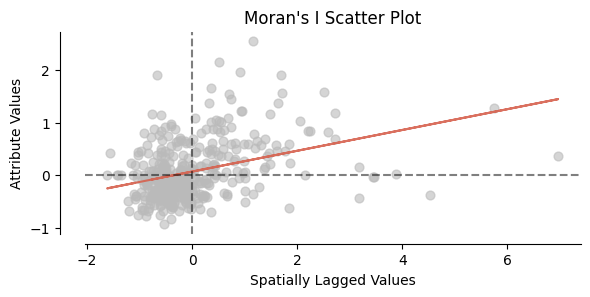

In [35]:
brexit = gpd.read_file("C:\\Users\\rober\\OneDrive\\المستندات\\MADE Metropolitan Data 1 Assignments Robert\\brexit.gpkg") 
W = weights.Queen.from_dataframe(brexit)
y = brexit['Valid_Vote'].values 
plot_moran(W, y)